In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'step_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [4]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [5]:
import os
import pickle
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score


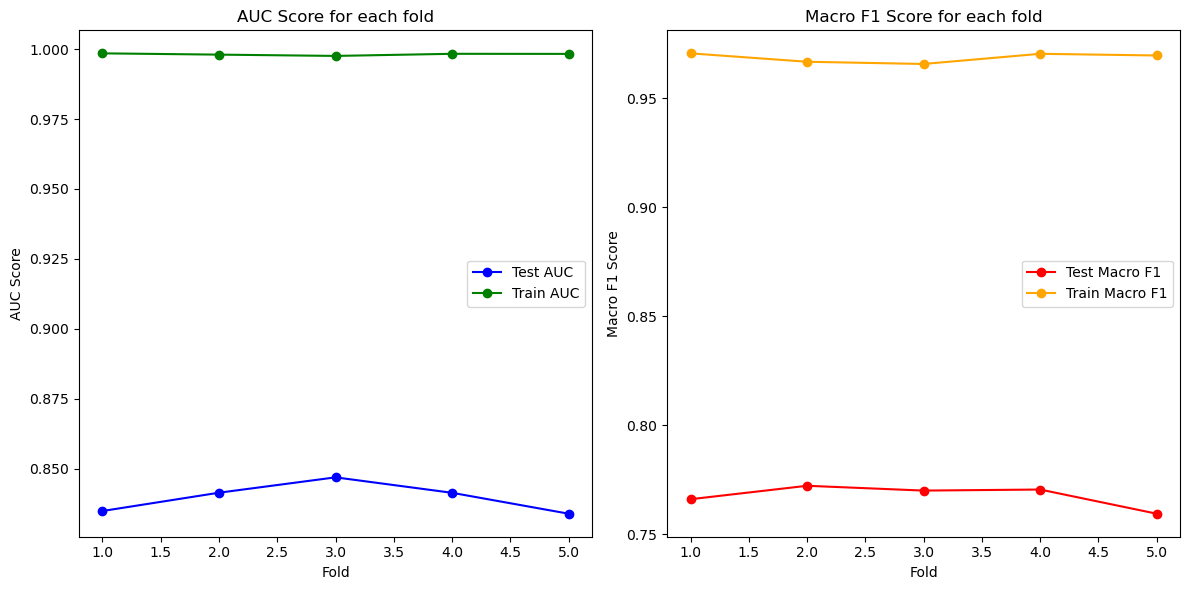

Mean Test AUC Score: 0.8396932783764364
Mean Train AUC Score: 0.9981432080402396
Mean Test Macro F1 Score: 0.7677411862017203
Mean Train Macro F1 Score: 0.9686079873312657


In [6]:
# Convert X and y to numpy arrays if they are not already
if isinstance(X, (pd.DataFrame, pd.Series)):
    X = X.values
if isinstance(y, (pd.DataFrame, pd.Series)):
    y = y.values

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost model
model = xgb.XGBClassifier()

# Arrays to store metrics for each fold
train_auc_scores = []
test_auc_scores = []
train_macro_f1_scores = []
test_macro_f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc_scores.append(roc_auc_score(y_train, y_train_pred_proba))
    test_auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))
    train_macro_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_macro_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_auc_scores) + 1), test_auc_scores, marker='o', linestyle='-', color='b', label='Test AUC')
plt.plot(range(1, len(train_auc_scores) + 1), train_auc_scores, marker='o', linestyle='-', color='g', label='Train AUC')
plt.title('AUC Score for each fold')
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_macro_f1_scores) + 1), test_macro_f1_scores, marker='o', linestyle='-', color='r', label='Test Macro F1')
plt.plot(range(1, len(train_macro_f1_scores) + 1), train_macro_f1_scores, marker='o', linestyle='-', color='orange', label='Train Macro F1')
plt.title('Macro F1 Score for each fold')
plt.xlabel('Fold')
plt.ylabel('Macro F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Mean Test AUC Score: {np.mean(test_auc_scores)}')
print(f'Mean Train AUC Score: {np.mean(train_auc_scores)}')
print(f'Mean Test Macro F1 Score: {np.mean(test_macro_f1_scores)}')
print(f'Mean Train Macro F1 Score: {np.mean(train_macro_f1_scores)}')

Group Kfold

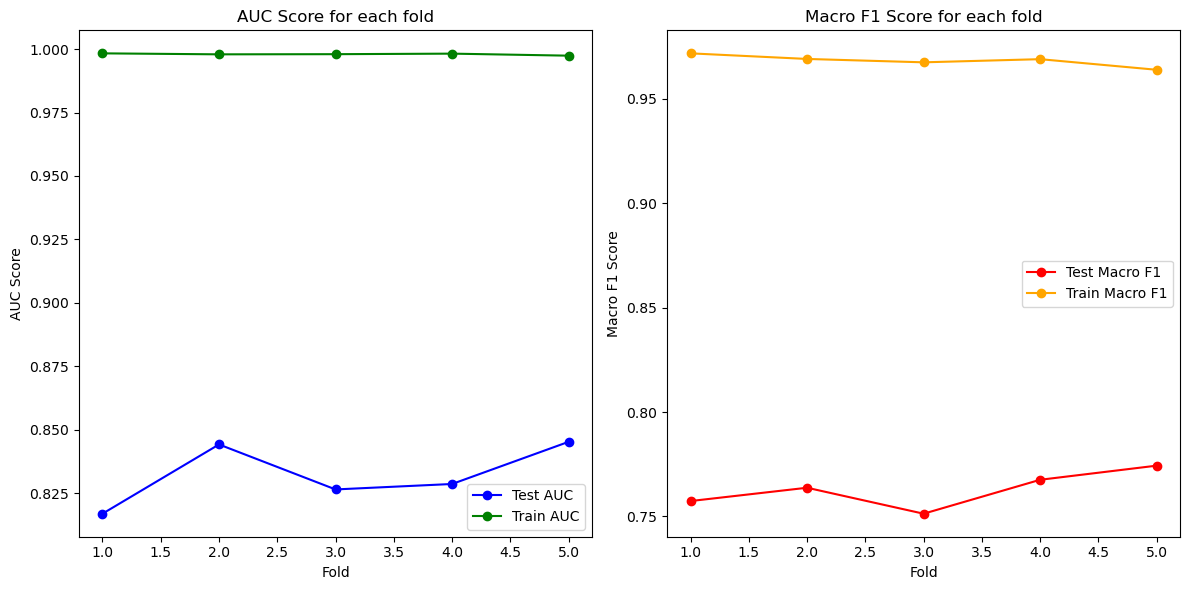

Mean Test AUC Score: 0.8322381395497462
Mean Train AUC Score: 0.9979970951461136
Mean Test Macro F1 Score: 0.7628618419713048
Mean Train Macro F1 Score: 0.9682963853419757


In [7]:
import os
import pickle
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score


# Convert X and y to numpy arrays if they are not already
if isinstance(X, (pd.DataFrame, pd.Series)):
    X = X.values
if isinstance(y, (pd.DataFrame, pd.Series)):
    y = y.values

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Initialize XGBoost model
model = xgb.XGBClassifier()

# Arrays to store metrics for each fold
train_auc_scores = []
test_auc_scores = []
train_macro_f1_scores = []
test_macro_f1_scores = []

for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc_scores.append(roc_auc_score(y_train, y_train_pred_proba))
    test_auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))
    train_macro_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_macro_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_auc_scores) + 1), test_auc_scores, marker='o', linestyle='-', color='b', label='Test AUC')
plt.plot(range(1, len(train_auc_scores) + 1), train_auc_scores, marker='o', linestyle='-', color='g', label='Train AUC')
plt.title('AUC Score for each fold')
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_macro_f1_scores) + 1), test_macro_f1_scores, marker='o', linestyle='-', color='r', label='Test Macro F1')
plt.plot(range(1, len(train_macro_f1_scores) + 1), train_macro_f1_scores, marker='o', linestyle='-', color='orange', label='Train Macro F1')
plt.title('Macro F1 Score for each fold')
plt.xlabel('Fold')
plt.ylabel('Macro F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Mean Test AUC Score: {np.mean(test_auc_scores)}')
print(f'Mean Train AUC Score: {np.mean(train_auc_scores)}')
print(f'Mean Test Macro F1 Score: {np.mean(test_macro_f1_scores)}')
print(f'Mean Train Macro F1 Score: {np.mean(train_macro_f1_scores)}')

ESM LAbels

In [8]:
p = os.path.join(PATH_INTERMEDIATE, 'stress_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [9]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [10]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [11]:
import os
import pickle
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score


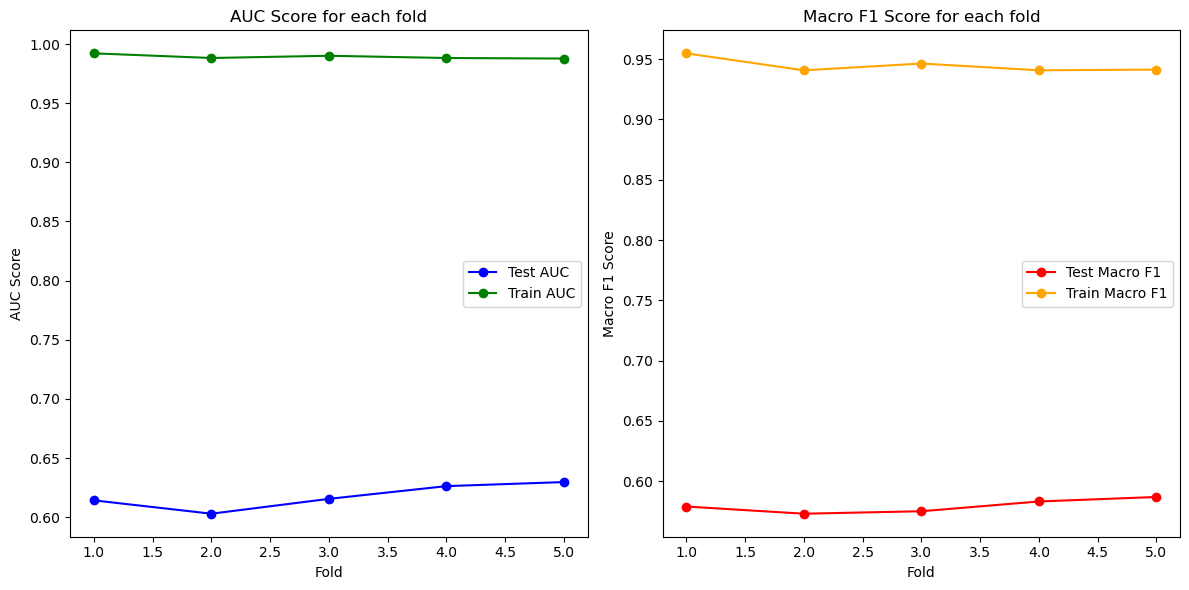

Mean Test AUC Score: 0.6177241227091992
Mean Train AUC Score: 0.9893067397068513
Mean Test Macro F1 Score: 0.5794636848607161
Mean Train Macro F1 Score: 0.9447904265425752


In [12]:
# Convert X and y to numpy arrays if they are not already
if isinstance(X, (pd.DataFrame, pd.Series)):
    X = X.values
if isinstance(y, (pd.DataFrame, pd.Series)):
    y = y.values

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost model
model = xgb.XGBClassifier()

# Arrays to store metrics for each fold
train_auc_scores = []
test_auc_scores = []
train_macro_f1_scores = []
test_macro_f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc_scores.append(roc_auc_score(y_train, y_train_pred_proba))
    test_auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))
    train_macro_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_macro_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_auc_scores) + 1), test_auc_scores, marker='o', linestyle='-', color='b', label='Test AUC')
plt.plot(range(1, len(train_auc_scores) + 1), train_auc_scores, marker='o', linestyle='-', color='g', label='Train AUC')
plt.title('AUC Score for each fold')
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_macro_f1_scores) + 1), test_macro_f1_scores, marker='o', linestyle='-', color='r', label='Test Macro F1')
plt.plot(range(1, len(train_macro_f1_scores) + 1), train_macro_f1_scores, marker='o', linestyle='-', color='orange', label='Train Macro F1')
plt.title('Macro F1 Score for each fold')
plt.xlabel('Fold')
plt.ylabel('Macro F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Mean Test AUC Score: {np.mean(test_auc_scores)}')
print(f'Mean Train AUC Score: {np.mean(train_auc_scores)}')
print(f'Mean Test Macro F1 Score: {np.mean(test_macro_f1_scores)}')
print(f'Mean Train Macro F1 Score: {np.mean(train_macro_f1_scores)}')

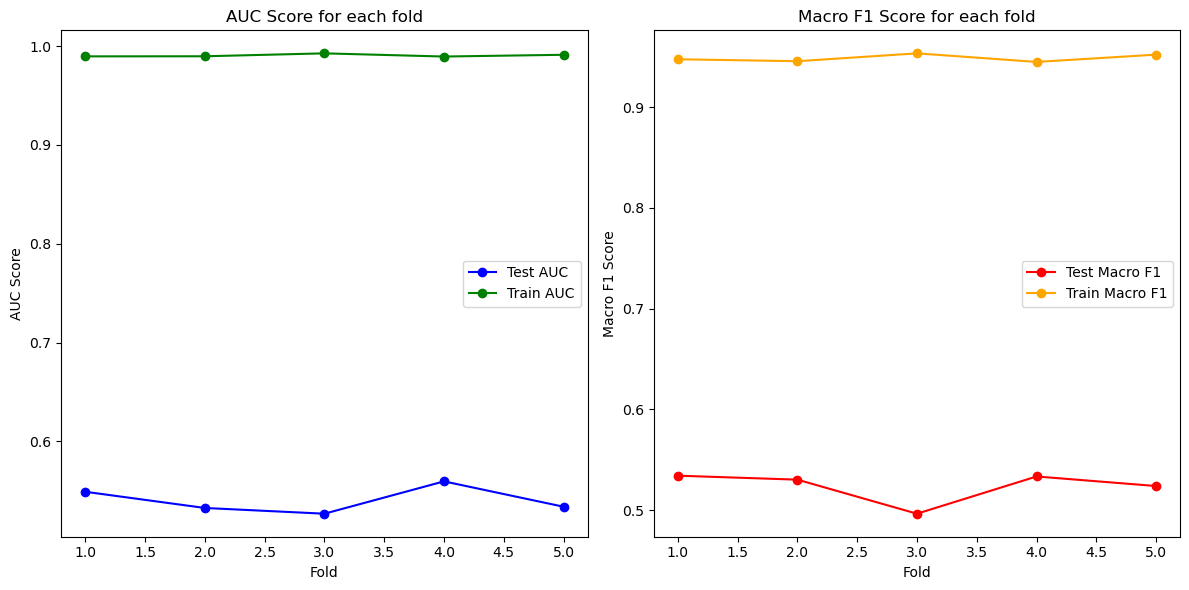

Mean Test AUC Score: 0.5404225311335156
Mean Train AUC Score: 0.9904385008727129
Mean Test Macro F1 Score: 0.5238001226546638
Mean Train Macro F1 Score: 0.948597646928515


In [13]:
import os
import pickle
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score


# Convert X and y to numpy arrays if they are not already
if isinstance(X, (pd.DataFrame, pd.Series)):
    X = X.values
if isinstance(y, (pd.DataFrame, pd.Series)):
    y = y.values

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Initialize XGBoost model
model = xgb.XGBClassifier()

# Arrays to store metrics for each fold
train_auc_scores = []
test_auc_scores = []
train_macro_f1_scores = []
test_macro_f1_scores = []

for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc_scores.append(roc_auc_score(y_train, y_train_pred_proba))
    test_auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))
    train_macro_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
    test_macro_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_auc_scores) + 1), test_auc_scores, marker='o', linestyle='-', color='b', label='Test AUC')
plt.plot(range(1, len(train_auc_scores) + 1), train_auc_scores, marker='o', linestyle='-', color='g', label='Train AUC')
plt.title('AUC Score for each fold')
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_macro_f1_scores) + 1), test_macro_f1_scores, marker='o', linestyle='-', color='r', label='Test Macro F1')
plt.plot(range(1, len(train_macro_f1_scores) + 1), train_macro_f1_scores, marker='o', linestyle='-', color='orange', label='Train Macro F1')
plt.title('Macro F1 Score for each fold')
plt.xlabel('Fold')
plt.ylabel('Macro F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Mean Test AUC Score: {np.mean(test_auc_scores)}')
print(f'Mean Train AUC Score: {np.mean(train_auc_scores)}')
print(f'Mean Test Macro F1 Score: {np.mean(test_macro_f1_scores)}')
print(f'Mean Train Macro F1 Score: {np.mean(train_macro_f1_scores)}')